# 4.1- AB Testing

![ab_test](https://email.uplers.com/blog/wp-content/uploads/2020/07/A-B-Testing.jpg)


### Step by step guide

We will see the entire process of an AB test, from formulating the hypothesis, putting it to the test and finally interpreting the results. We will use the data from [Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing?select=ab_data.csv) which contains the results of an AB test of two possible websites (the old version and the new one). )

The process will be as follows:

1. [Design the experiment](#1.-Design-the-experiment)
2. [Get and prepare data](#2.-Get-and-prepare-data)
3. [View the results](#3.-View-the-results)
4. [Test the hypothesis](#4.-Test-the-hypothesis)
5. [Interpret results](#5.-Interpret-results)

To contextualise, let's imagine the following case study:

![abtest](https://email.uplers.com/blog/wp-content/uploads/2020/07/A-B-Testing.jpg)

> We work in the product team of an **online e-commerce company**. The UX team is working very hard on the new version of the product page, with the aim of achieving higher conversion rates. The PM (product manager) tells us that the current version of the page achieves a **conversion rate of 13% on average per year**. The annual goal is a **2% increase**, which implies that the new version must achieve a 15% conversion rate.

Before making the final change to the page, it is necessary to carry out tests to verify that it really works. It is at that moment where the **AB test** performed on a group of users appears.

***
### 1. Design the experiment


#### Formulating a hypothesis

After observing the need for a test, it is necessary to formulate a hypothesis. Since we don't know if the new page works better or worse, we will use the [two-tailed test](https://en.wikipedia.org/wiki/One-_and_two-tailed_tests):

$$H_0: p = p_0$$
$$H_1: p \ne p_0$$

where $p$ and $p_0$ are the conversion rates of the new web design and the old design respectively. In addition, we set a**95% confidence interval**:

$$\alpha = 0.05$$

The value of $\alpha$ is the threshold for that confidence interval, which means that "if the probability of observing an outcome, the $p$-value, is less than $\alpha$, then we can reject the null hypothesis." Our $\alpha=0.05$ indicates a 5% probability, giving a confidence interval, 1 - $\alpha$, of 95%.



#### Choosing the variables

For our test we need**two groups**:
* A `control` group - This will be the group that sees the old web design
* A `treatment`, or experimental group - This will be the group that sees the new layout of the page

This will be our *independent variable*. The reason for having two groups even though we already know the current conversion rate is that we want to control for other variables that could affect the results, such as seasonality. Having a `control` group we can directly compare the results with the `treatment` group, because the only systematic difference between the two groups is the design of the product web page, and we can assume the difference between them due to that design. .

The *dependent variable*, the one we are trying to measure, is the `conversion rate`. One way to record it is through a binary log:
* `0` - User who does not buy during his visit to the web.
* `1` - User who buys on the web.




#### Choosing the sample size

It is important to note that we are not going to do the test on our entire database, so what we will actually get are estimates. The number of people, or sessions, that we decide to capture from each group will have an effect on the estimate of our conversion rates. The larger the sample, the more precise our estimate will be, and the more precise our estimate, the higher the chances of detecting differences between groups if they exist.

On the other hand, the larger the sample, the more expensive and impractical the study becomes.

*So, how many people should be in each group?*

To estimate the size in this case, we will use what is known as the power of a statistical test or the [statistical power](https://es.wikipedia.org/wiki/Poder_estad%C3%ADstico), which depends on several values:***Power of the test**($1 - \beta$) - Represents the probability of finding a statistically significant difference between the groups. By convention it is usually set at 0.8***Threshold (p-value)**($\alpha$) - Critical value previously set to 0.05

***Effect Size** - How large is the expected difference between the conversion rates. Our goal was 2%

In [27]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as sms

import pylab as plt
import seaborn as sns

%matplotlib inline

https://www.statsmodels.org/dev/generated/statsmodels.stats.power.NormalIndPower.solve_power.html

In [28]:
# calculate the effect size. from 13% to 15%

effect=sms.proportion_effectsize(0.13, 0.15)

effect

-0.0576728617308947

In [29]:
# sample size

n_required = sms.NormalIndPower().solve_power(effect,
                                               power=0.8,
                                               alpha=0.05)

n_required

4719.4740575998185

We need **at least 4720 observations for each group**.

Setting the 'power' to 0.8 implies that if there is a significant difference between conversion rates, we have an 80% chance of detecting it with this sample size.

***
### 2. Obtain and prepare data


We obtain the dataframe and proceed to examine it and prepare it for the study. We will choose a random sample of 4720 records for each group.

In [ ]:
df=pd.read_csv('../data/ab_data.csv')

df.head()

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [38]:
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


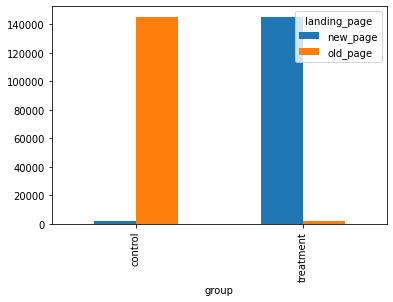

In [39]:
pd.crosstab(df.group, df.landing_page).plot(kind='bar');

In [40]:
df.shape

(294478, 5)

We remove users with multiple visits to the website.

In [41]:
sesiones = df.user_id.value_counts(ascending=False)

sesiones[sesiones>1].count()

3894

In [42]:
drop_usuarios = sesiones[sesiones>1].index

df=df[~df.user_id.isin(drop_usuarios)]

df.shape

(286690, 5)

In [43]:
pd.crosstab(df.group, df.landing_page)

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


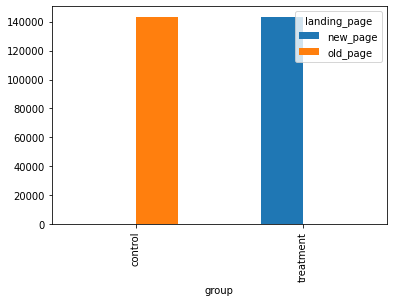

In [44]:
pd.crosstab(df.group, df.landing_page).plot(kind='bar');

**Sampling**

In [48]:
control = df[df.group=='control'].sample(n=4720, random_state=22)

experimental = df[df.group=='treatment'].sample(n=4720, random_state=22)

ab_test=pd.concat([control, experimental], axis=0)

ab_test.reset_index(drop=True, inplace=True)

ab_test.head()


,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0


In [49]:
ab_test.tail()

,user_id,timestamp,group,landing_page,converted
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0
9439,944623,2017-01-19 10:56:01.648653,treatment,new_page,1


In [50]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [51]:
ab_test.group.value_counts()

group
control      4720
treatment    4720
Name: count, dtype: int64

We already have the samples we need to carry out the study.

***
### 3. View the results

We perform some descriptive calculations:

In [52]:
tasas_conversion = ab_test.groupby('group')['converted']    # agrupacion por grupo


std = lambda x: np.std(x, ddof=0)              # std
error_std= lambda x: stats.sem(x, ddof=0)      # sem = std/sqrt(n)

tasas_conversion = tasas_conversion.agg([np.mean, std, error_std])

tasas_conversion.columns = ['conversion_rate', 'std', 'sem']

tasas_conversion.style.format('{:.3f}')

,conversion_rate,std,sem
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


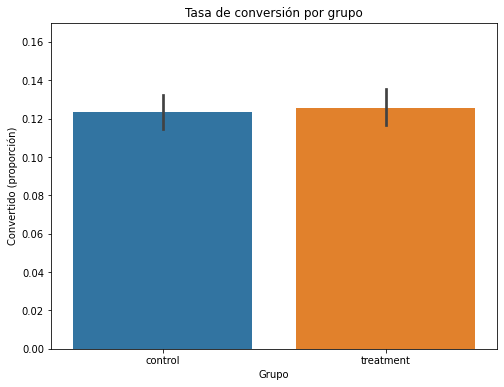

In [53]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], 
            y=ab_test['converted'])

plt.ylim(0, 0.17)
plt.title('Tasa de conversión por grupo')
plt.xlabel('Grupo')
plt.ylabel('Convertido (proporción)');

The conversion rates for both groups are very close. The conversion rate of the `control` group is lower than expected (12.3% vs. 13% that we had been told).

So the `treatment` group has a higher conversion rate. **Is this difference statistically significant?**

***
### 4. Test the hypothesis

The last step is to test our hypothesis. We have a sufficient sample to use the z-test.

We can use `statsmodels.stats.proportion` to get the $p$-values ​​and confidence intervals:

In [54]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [55]:
# seleccionar grupos

control_res=ab_test[ab_test.group=='control']['converted']

exp_res=ab_test[ab_test.group=='experimental']['converted']

In [56]:
observaciones=[4720, 4720]  # count
    
conversiones=[control_res.sum(), exp_res.sum()]


z_score, p_value = proportions_ztest(conversiones, nobs=observaciones)

(control_a, exp_a), (control_b, exp_b) = proportion_confint(conversiones, 
                                                                nobs=observaciones,
                                                                alpha=0.05)

In [57]:
print(f'z-score: {z_score:.2f}')

print(f'p-valor: {p_value:.3f}')

print(f'intervalo conf 95% para grupo control: [{control_a:.3f}, {control_b:.3f}]')

print(f'intervalo conf 95% para grupo experimental: [{exp_a:.3f}, {exp_b:.3f}]')

z-score: 24.90
p-valor: 0.000
intervalo conf 95% para grupo control: [0.114, 0.133]
intervalo conf 95% para grupo experimental: [0.000, 0.000]


***
### 5. Interpret results

Since $p$-value=0.732 is greater than $\alpha$=0.05, we cannot reject the null hypothesis $H_0$, which means that the new page layout does not perform significantly differently from the old layout.

Additionally, if we look at the confidence interval for the `treatment` group ([0.116, 0.135], i.e. 11.6-13.5%) we realize that:
1. Includes our base value of 13% in the conversion rate
2. Does not include our target value of 15% (the 2% increase we were looking for)

All this implies that the conversion rate of the new design is most likely to be similar to the old design of the web, and would not reach that 15% sought. This would prove that the design does not improve our conversion rate and that we should go back to the design table.

In [58]:
tasas_conversion

,conversion_rate,std,sem
group,,,
control,0.123305,0.328787,0.004786
treatment,0.125636,0.331438,0.004824


In [59]:
from scipy.stats import norm

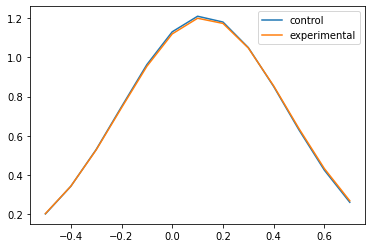

In [60]:
x=[i*.1 for i in range(-5, 8)]  

control=[norm.pdf(x, tasas_conversion.iloc[0][0], tasas_conversion.iloc[0][1]) for x in x] 

experimental=[norm.pdf(x, tasas_conversion.iloc[1][0], tasas_conversion.iloc[1][1]) for x in x] 

plt.plot(x, control)
plt.plot(x, experimental)
plt.legend(['control', 'experimental']);